<font size="40"> Ships recognition in satellite images</font>

# Executive summary

## Problem setup
Satellite imagery provides unique insights into various markets, including agriculture, defense and intelligence, energy, and finance. New commercial imagery providers, such as Planet, are using constellations of small satellites to capture images of the entire Earth every day.

This flood of new imagery is outgrowing the ability for organizations to manually look at each image that gets captured, and there is a need for machine learning and computer vision algorithms to help automate the analysis process.

## Solution
This notebook describes building a CNN (convolutional neural network) capable of distinguishing whether a presented satellite image has a ship on it. I use transfer learning on two publicly available pretrained CNNs (VGG16 and Inception), building classifiers on top of them, and compare those.
1. The dataset [Ships in Satellite Imagery](https://www.kaggle.com/rhammell/ships-in-satellite-imagery) has 1000 positive (ship) and 3000 negative examples, with each image being 80x80 px RGB
2. Final classifiers provide @@ accuracy on unseen data

# Pipeline description

This is an overview of the entire project structure, or pipeline:
1. Aquire the data from a public dataset on kaggle
2. Perform basic EDA (exploratory data analysis)
3. Use data augmentation to compensate for skewness (there is only on ship example for each 3 no-ships)
4. Use pretrained CNNs (VGG16 and Inception) to calculate feature vectors for each image
5. Split the data into train/dev/test sets
6. Build and train classifiers on top of the pretrained CNNs
7. Use the dev set to perform hyperparameters optimization and choose the best solution (combination of pretrained CNN + new classifier)
8. Use the test set to estimate the real-world performance of the algorithm on unseen data

# Setup

In [281]:
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

import os
import tempfile

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import imgaug.augmenters as iaa # data augmentation
from tqdm import tqdm # progress bar for loops
import cv2 # OpenCV for computer vision
import seaborn as sns # heatmap plotting
from varname import nameof # surprisingly one needs a special package to extract a variable name as a string!

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.layers import Dense, Dropout # layers to build my classifiers
from tensorflow.keras import Sequential, optimizers # layer stacking and optimizers

# from tensorflow.keras.utils import to_categorical # one-hot encoding

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Data wrangling

## Load data
The data was downloaded manually and separated into ship and no-ship folders

In [3]:
data_location = 'data/shipsnet'
class_names = ["no-ship","ship"]
class_name_labels = {class_name:i for i,class_name in enumerate(class_names)} # dictionary of class names: ids
num_classes = len(class_names)
class_name_labels

{'no-ship': 0, 'ship': 1}

Load images as CV2 format, normalize pixel values and read labels

In [4]:
images, labels = [], []
     
for folder in os.listdir(data_location):
    label = class_name_labels[folder]

    for file in tqdm(os.listdir(os.path.join(data_location,folder))):

        img_path = os.path.join(data_location,folder,file)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # OpenCV loads images as BGR while matplotlib will need RGB to display them

        images.append(img)
        labels.append(label)
        pass
    pass

images = np.array(images,dtype=np.float32) /255.0 # Normalize data
labels = np.array(labels,dtype=np.int32)

images.shape, labels.shape

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2248.16it/s]


((4000, 80, 80, 3), (4000,))

## EDA
Let's see the distribution of data betweeen classes

In [5]:
n_labels = labels.shape[0]

_, count = np.unique(labels, return_counts=True)

df = pd.DataFrame(data = count)
df['Class Label'] = class_names
df.columns = ['Count','Class-Label']
df.set_index('Class-Label',inplace=True)
df

,Count
Class-Label,
no-ship,3000
ship,1000


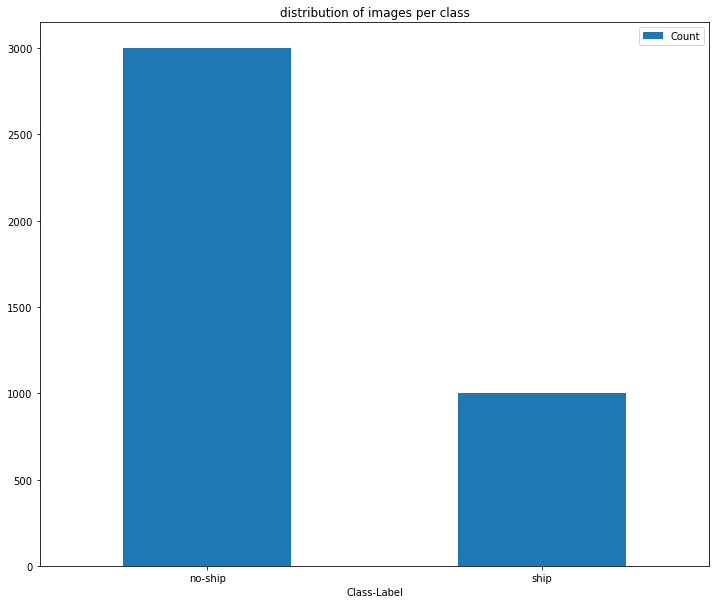

In [6]:
df.plot.bar(rot=0)
plt.title("distribution of images per class");

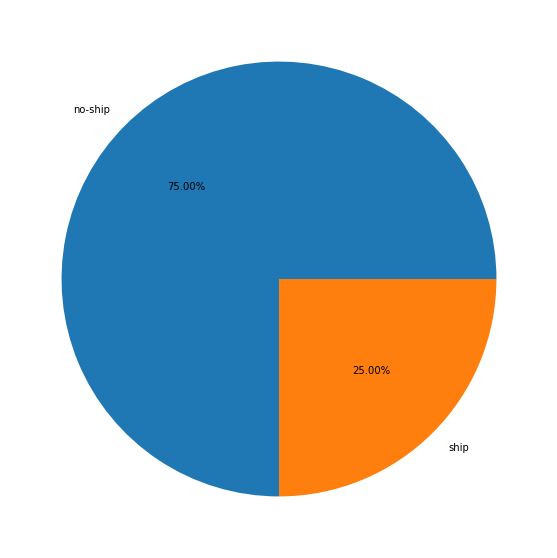

In [7]:
plt.pie(count,
       explode=(0,0),
       labels=class_names,
       autopct="%1.2f%%");

**For each ship image, there are 3 no-ship ones.** Such skewness will have to be corrected for, otherwise the alogrithm will be able to achieve 75% accuracy just by always predicting "no-ship" which will create unnecessary bias.

Let's now see a few images. First row is no-ship, second row are ships.

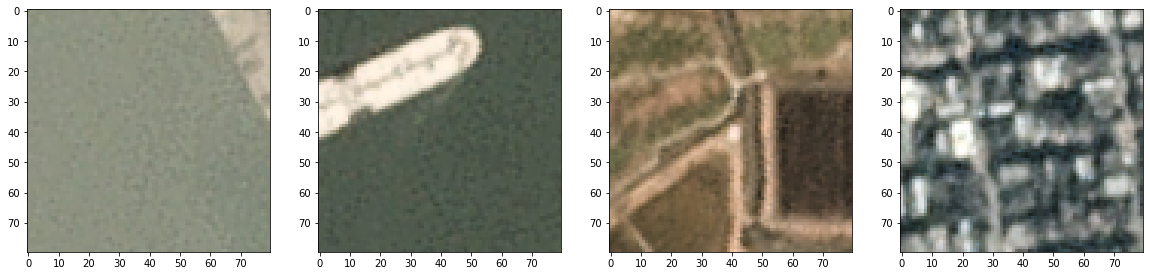

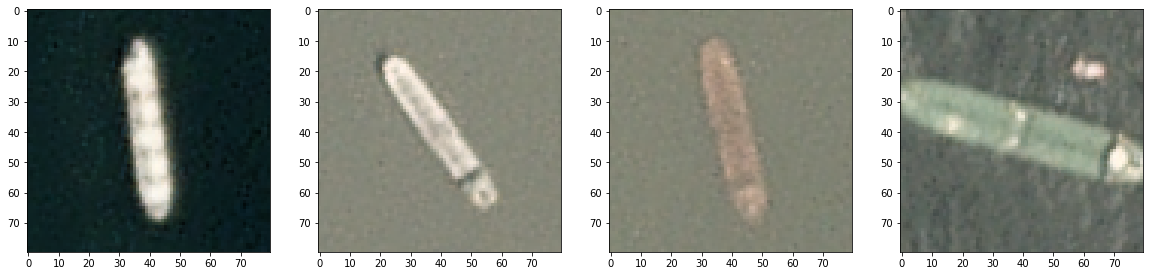

In [8]:
columns = 4
rows = 1

# no ships are images from 0 to 3000
fig=plt.figure(figsize=(20, 20))
for i in range(1, columns*rows +1):
    img = images[np.random.choice(3000)]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# ships are from 3000 to 4000
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 1
for i in range(1, columns*rows +1):
    img = images[np.random.choice(1000)+3000]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()


It is worth noting that only a full image of the vessel is considered to belong to ship class. No-ship sometimes can contain a part of a ship.

## Train/dev/test split

I will split the entire dataset into train/dev/test using 70/20/10 ratio appropriate for a relatively small number of examples I have.
1. Train set will be used to train classifiers
2. Dev set, a.k.a. validation set, will be used to compare different approaches with each other and choose the best one. Each one comprises:
    + underlying pretrained CNN
    + classifier with its hyperparameters
    + a choice of correcting for skewed classes: either data augmentation or class weights
3. Test set will be used only once to estimate the performance of the best model on unseen data

`train_test_split` function from `scikitlearn` only allows splitting into two sets (train and test), so I will use it twice, first splitting all data into train and test, and then splitting test further into dev and test proper

In [14]:
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.3, random_state=42)
images_dev, images_test, labels_dev, labels_test = train_test_split(images_test, labels_test, test_size=1/3, random_state=43)
images_train.shape, images_dev.shape, images_test.shape

((2800, 80, 80, 3), (800, 80, 80, 3), (400, 80, 80, 3))

# Transfer learning
The amount of original data (only 4000 examples) is not enough to train a CNN from scratch. It makes more sense to reuse some publicly available models that have been trained over several weeks using GPU on millions of examples. Thus I will be able to transfer the existing knowledge about low-level features (borders, angles etc) and only learn the actual classification between ships and no-ships.

This will be a two step process:
1. Use pretrained CNN (without the final fully connected and classifier layers) to calculate feature vectors for each image (deterministic step, as no training will be done here)
2. Build and train a separate classifier, using feature vectors from step 1 as an input

Generally speaking, the classifier at step 2 does not have to be a neural network at all. One can use SVM, logistic regression or anything at all, but I will stick to NN as this is the topic of the whole notebook.

## VGG16

VGG16 is a deep CNN with 16 trainable layers that made history by achieving 92.7% top-5 test accuracy on ILSVRC-2014 competition by ImageNet. You can read about it [in this article](https://neurohive.io/en/popular-networks/vgg16/), but here is the architecture for general understanding. 

![VGG16 architecture](vgg16.png "VGG16 architecture")

### Load model

There are two parts to a CNN model: the network architecture (displayed above) and the weights after training. For transfer learning, we'll need both, and both very conveniently are now available via keras package.

However, out of VGG16 original 16 trainable layers (not counting pooling and softmax), only the first 13 are convolutional layers, and last 3 are fully connected ones that perform  classification. I will only load the convolutional layers and build my own classifier on top of that. A nice perk is that it will allow me to use any size image for input (generating different size features vectors for output), because otherwise VGG16 only accepts 256x256 px format.

In [15]:
vgg_conv = vgg16.VGG16(weights='imagenet', # loads the weights, first time they will be downloaded from the github but then saved locally
                  include_top=False, # do not load fully connected layers
                  input_shape=(80, 80, 3)) # shape of the images in ships dataset

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Calculate features

First pass all the images through VGG16 to get feature tensors. With a 256x256x3 image, the result would be 7x7x256, but with a 80x80x3 ones that I am using it will be smaller, some kind of n x n x 256, where n < 7. This step takes a few minutes.

In [16]:
vgg_train, vgg_dev, vgg_test = vgg_conv.predict(images_train), vgg_conv.predict(images_dev), vgg_conv.predict(images_test)
vgg_train.shape, vgg_dev.shape, vgg_test.shape

((2800, 2, 2, 512), (800, 2, 2, 512), (400, 2, 2, 512))

Okay resulting tensors are 2x2x512. Need to flatten them into feature vectors because this is what fully connected layers like.

In [17]:
def flatten(tensor): # this function will be reused when flattening Inception features that have a different shape
    return np.reshape(tensor, (tensor.shape[0], tensor.shape[1] * tensor.shape[2] * tensor.shape[3]))

vgg_train, vgg_dev, vgg_test = flatten(vgg_train), flatten(vgg_dev), flatten(vgg_test)
vgg_train.shape, vgg_dev.shape, vgg_test.shape

((2800, 2048), (800, 2048), (400, 2048))

Perfect, now each image is represented with a 2048-long feature vector.

## Inception

While VGG is conceptually a bunch of convolutional layers stacked upon each other, Inception has more complicated structure. Fully describing it is out of scope of this notebook (you can read a good overview [here](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202)). I will only mention that it creates a "sparsely connected architecture" by stacking up a new kind of bricks called "Inception modules":
![Inception module](inception_module.png "Inception module")

Among other things, this makes the network less expensive to train and less prone to overfitting.

For my particular task, I will just load the architecture and weights (without the top fully connected layers) and use them to calculate feature vectors as with VGG.

### Load model

In [18]:
incep_conv = inception_v3.InceptionV3(weights='imagenet', 
                  include_top=False,
                  input_shape=(80, 80, 3))

### Calculate features

By analogy with VGG, first get features as tensors:

In [19]:
incep_train, incep_dev, incep_test = incep_conv.predict(images_train), incep_conv.predict(images_dev), incep_conv.predict(images_test)
incep_train.shape, incep_dev.shape, incep_test.shape

((2800, 1, 1, 2048), (800, 1, 1, 2048), (400, 1, 1, 2048))

It's interesting that both VGG16 and Inception end up with the same size features, although shaped differently.

Now flatten:

In [20]:
incep_train, incep_dev, incep_test = flatten(incep_train), flatten(incep_dev), flatten(incep_test)
incep_train.shape, incep_dev.shape, incep_test.shape

((2800, 2048), (800, 2048), (400, 2048))

# Own model (classifier)

Due to the lucky coincidence that VGG16 and Inception output feature vectors of the same size, I can use the same classifier architurecture, feed it both outputs and compare.

## Define architecture and metrics

0. Input is 2048-length feature vector
1. Fully connected layer with 1024 neurons and ReLU activation
2. Dropout with 0.5
3. Single-unit output layer with sigmoid activation: standard choice for binary classification

In [144]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS):
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_dim=2048, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=40)))
    model.compile(optimizer=optimizers.RMSprop(lr=2e-4),
              loss='binary_crossentropy', # Using binary crossentropy cuz it's a binary classification problem
              metrics=metrics)
    return model

### Understanding useful metrics

Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.


*   **False** negatives and **false** positives are samples that were **incorrectly** classified
*   **True** negatives and **true** positives are samples that were **correctly** classified
*   **Accuracy** is the percentage of examples correctly classified
>   $\frac{\text{true samples}}{\text{total samples}}$
*   **Precision** is the percentage of **predicted** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   **Recall** is the percentage of **actual** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$
*   **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.
*   **F1** score is a way to take into account both precision and recall by taking their harmonic mean. This metric will be calculated manually in the end when comparing different models.
>   $2 ⋅ \frac{\text{precision ⋅ recall}}{\text{precision + recall}}$

Note: Accuracy is may not be the best metric for this task. You can achieve 75% accuracy by always predicting no-ship. However, it cannot be discarded completely. Read more:
* [True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
* [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
* [Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
* [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
* [F1 score](https://en.wikipedia.org/wiki/F-score)

## Build a model
Create a classifier using the previously defined function. This baseline version will probably not work very well and will be improved in later sections.

In [145]:
EPOCHS = 100
BATCH_SIZE = 32

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [151]:
np.random.seed(32)
tf.set_random_seed(33)

model = make_model()
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_20 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 1025      
Total params: 2,099,201
Trainable params: 2,099,201
Non-trainable params: 0
_________________________________________________________________


## Save initial weights

Saving initial weights to a temp file so that I can load them and re-train from the same point later.

In [156]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

## Baseline model

In this section, I will train two classifiers, using VGG16 and Inception embeddings as input, without correcting for the imbalanced classes.

### VGG16 baseline

#### Train model

In [157]:
# Train VGG classifier (or rather my own classifier on top of VGG convolutional layers)
vgg_model = make_model()
vgg_model.load_weights(initial_weights)
baseline_vgg_history = vgg_model.fit(
    vgg_train,
    labels_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(vgg_dev, labels_dev))

Train on 2800 samples, validate on 800 samples
Epoch 1/100
2800/2800 [==============================] - 3s 1ms/sample - loss: 0.1401 - tp: 625.0000 - fp: 55.0000 - tn: 2029.0000 - fn: 91.0000 - accuracy: 0.9479 - precision: 0.9191 - recall: 0.8729 - auc: 0.9843 - val_loss: 0.1134 - val_tp: 188.0000 - val_fp: 35.0000 - val_tn: 573.0000 - val_fn: 4.0000 - val_accuracy: 0.9513 - val_precision: 0.8430 - val_recall: 0.9792 - val_auc: 0.9956
Epoch 2/100
2800/2800 [==============================] - 2s 720us/sample - loss: 0.0563 - tp: 685.0000 - fp: 25.0000 - tn: 2059.0000 - fn: 31.0000 - accuracy: 0.9800 - precision: 0.9648 - recall: 0.9567 - auc: 0.9975 - val_loss: 0.0537 - val_tp: 183.0000 - val_fp: 11.0000 - val_tn: 597.0000 - val_fn: 9.0000 - val_accuracy: 0.9750 - val_precision: 0.9433 - val_recall: 0.9531 - val_auc: 0.9976
Epoch 3/100
2800/2800 [==============================] - 2s 722us/sample - loss: 0.0409 - tp: 695.0000 - fp: 19.0000 - tn: 2065.0000 - fn: 21.0000 - accuracy: 0.9857

#### Plot training history

In [170]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.98,1])
    else:
      plt.ylim([0.89,1])

    plt.legend()

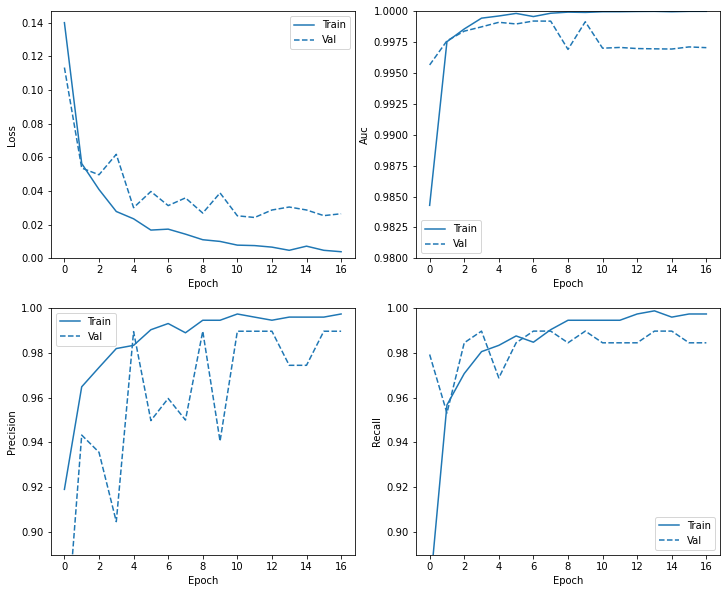

In [171]:
plot_metrics(baseline_vgg_history)

#### Evaluate metrics

One way to evaluate the resulting model is to use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels where the X axis is the predicted label and the Y axis is the actual label.

A function to plot the confusion matrix:

In [343]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('No-ships Detected (True Negatives): ', cm[0][0])
  print('No-ships Incorrectly Detected (False Positives): ', cm[0][1])
  print('Ships Missed (False Negatives): ', cm[1][0])
  print('Ships Detected (True Positives): ', cm[1][1])
  print('Total Ships: ', np.sum(cm[1]))
  return(cm)

loss :  0.048311117980629203
tp :  89.0
fp :  4.0
tn :  304.0
fn :  3.0
accuracy :  0.9825
precision :  0.9569892
recall :  0.9673913
auc :  0.9934359

No-ships Detected (True Negatives):  304
No-ships Incorrectly Detected (False Positives):  4
Ships Missed (False Negatives):  3
Ships Detected (True Positives):  89
Total Ships:  92


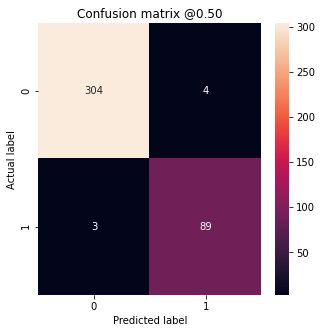

In [345]:
vgg_test_predictions_baseline = vgg_model.predict(vgg_test, batch_size=BATCH_SIZE)
vgg_baseline_eval = vgg_model.evaluate(vgg_test, labels_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(vgg_model.metrics_names, vgg_baseline_eval):
  print(name, ': ', value)
print()

_ = plot_cm(labels_test, vgg_test_predictions_baseline)

#### Plot the ROC

ROC curve is useful because it shows how you can tune your classifier by adjusting the prediction threshold. I will only plot it for test data as with a total of 6 models, the chart will be eventually quite cluttered already.

In [307]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,12.5])
  plt.ylim([87,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

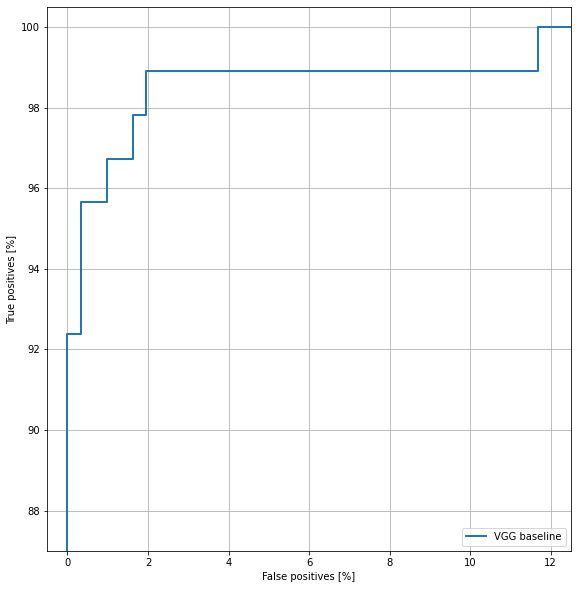

In [308]:
plot_roc("VGG baseline", labels_test, vgg_test_predictions_baseline, color=colors[0])
plt.legend(loc='lower right')

### Inception baseline

#### Train model

In [160]:
# load same initial weights as were used for VGG
incep_model = make_model()
incep_model.load_weights(initial_weights)

# train my classifier using Inception features
baseline_incep_history = incep_model.fit(
    incep_train,
    labels_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(incep_dev, labels_dev))

Train on 2800 samples, validate on 800 samples
Epoch 1/100
2800/2800 [==============================] - 4s 1ms/sample - loss: 0.1779 - tp: 598.0000 - fp: 96.0000 - tn: 1988.0000 - fn: 118.0000 - accuracy: 0.9236 - precision: 0.8617 - recall: 0.8352 - auc: 0.9749 - val_loss: 0.1096 - val_tp: 186.0000 - val_fp: 27.0000 - val_tn: 581.0000 - val_fn: 6.0000 - val_accuracy: 0.9588 - val_precision: 0.8732 - val_recall: 0.9688 - val_auc: 0.9919
Epoch 2/100
2800/2800 [==============================] - 2s 731us/sample - loss: 0.0860 - tp: 678.0000 - fp: 37.0000 - tn: 2047.0000 - fn: 38.0000 - accuracy: 0.9732 - precision: 0.9483 - recall: 0.9469 - auc: 0.9930 - val_loss: 0.0830 - val_tp: 187.0000 - val_fp: 17.0000 - val_tn: 591.0000 - val_fn: 5.0000 - val_accuracy: 0.9725 - val_precision: 0.9167 - val_recall: 0.9740 - val_auc: 0.9941
Epoch 3/100
2800/2800 [==============================] - 2s 724us/sample - loss: 0.0549 - tp: 690.0000 - fp: 27.0000 - tn: 2057.0000 - fn: 26.0000 - accuracy: 0.981

#### Plot training history

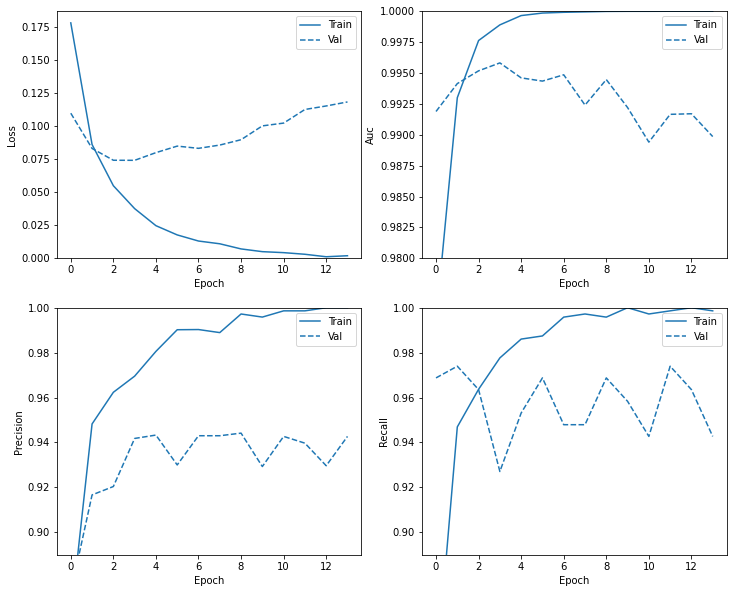

In [173]:
plot_metrics(baseline_incep_history)

We can see a severe case of overfitting. Training loss goes down, but dev loss goes up. Normally I would attempt to solve this with one of the following:
* stronger regularization (increasing dropout rate, adding L1/L2 regularization)
* simplifying network architecture (redicing the number of hidden nodes)
* getting more training data, maybe through data augmentation

However, in this case I have another network that is learning well enough using VGG features for input, so I will keep that as main candidate, but keep an eye on Inception too just out of curiosity.

#### Evaluate metrics

loss :  0.09401846636086703
tp :  86.0
fp :  5.0
tn :  303.0
fn :  6.0
accuracy :  0.9725
precision :  0.94505495
recall :  0.9347826
auc :  0.99347126

No-ships Detected (True Negatives):  303
No-ships Incorrectly Detected (False Positives):  5
Ships Missed (False Negatives):  6
Ships Detected (True Positives):  86
Total Ships:  92


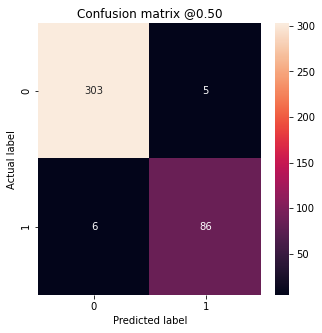

In [346]:
incep_test_predictions_baseline = incep_model.predict(incep_test, batch_size=BATCH_SIZE)
incep_baseline_eval = incep_model.evaluate(incep_test, labels_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(incep_model.metrics_names, incep_baseline_eval):
  print(name, ': ', value)
print()

_ = plot_cm(labels_test, incep_test_predictions_baseline)

As could be expected from training plots, the performance is not as good as VGG option, but still pretty decent. Maybe this classification task is just relatively easy by itself.

#### Plot the ROC

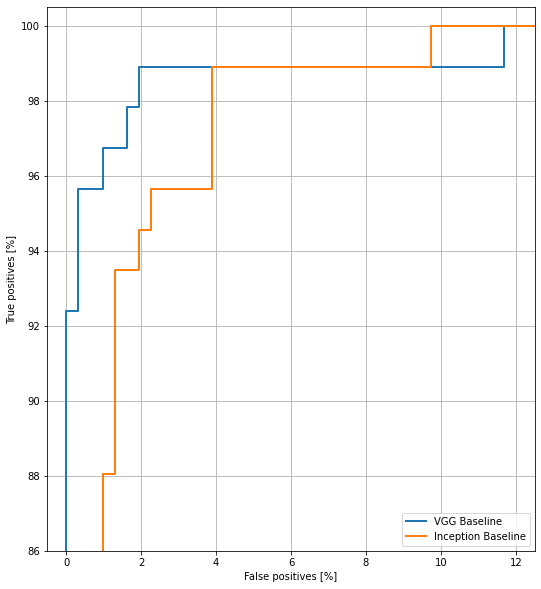

In [302]:
plot_roc("VGG Baseline", labels_test, vgg_test_predictions_baseline, color=colors[0])
plot_roc("Inception Baseline", labels_test, incep_test_predictions_baseline, color=colors[1])
plt.legend(loc='lower right')

## Class weights model

One option to improve the performance of a model on imbalanced data is to assign higher weight to the errors produced by minority class when training, making model "pay more attention" to the minority class.

### Calculcate class weights

In [163]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / df.loc['no-ship'].Count)*(sum(df.Count))/2.0 
weight_for_1 = (1 / df.loc['ship'].Count)*(sum(df.Count))/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.67
Weight for class 1: 2.00


### VGG 16 with class weights

#### Train a model with class weights
Keras has a special argument when training a model to pass the class weights.

In [164]:
weighted_vgg_model = make_model()
weighted_vgg_model.load_weights(initial_weights)

weighted_vgg_history = weighted_vgg_model.fit(
    vgg_train,
    labels_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(vgg_dev, labels_dev),
    # The class weights go here
    class_weight=class_weight) 

Train on 2800 samples, validate on 800 samples
Epoch 1/100
2800/2800 [==============================] - 4s 1ms/sample - loss: 0.1580 - tp: 672.0000 - fp: 128.0000 - tn: 1956.0000 - fn: 44.0000 - accuracy: 0.9386 - precision: 0.8400 - recall: 0.9385 - auc: 0.9863 - val_loss: 0.0795 - val_tp: 182.0000 - val_fp: 18.0000 - val_tn: 590.0000 - val_fn: 10.0000 - val_accuracy: 0.9650 - val_precision: 0.9100 - val_recall: 0.9479 - val_auc: 0.9961
Epoch 2/100
2800/2800 [==============================] - 2s 731us/sample - loss: 0.0610 - tp: 703.0000 - fp: 45.0000 - tn: 2039.0000 - fn: 13.0000 - accuracy: 0.9793 - precision: 0.9398 - recall: 0.9818 - auc: 0.9977 - val_loss: 0.0786 - val_tp: 190.0000 - val_fp: 24.0000 - val_tn: 584.0000 - val_fn: 2.0000 - val_accuracy: 0.9675 - val_precision: 0.8879 - val_recall: 0.9896 - val_auc: 0.9981
Epoch 3/100
2800/2800 [==============================] - 2s 741us/sample - loss: 0.0423 - tp: 706.0000 - fp: 28.0000 - tn: 2056.0000 - fn: 10.0000 - accuracy: 0.98

#### Plot training history

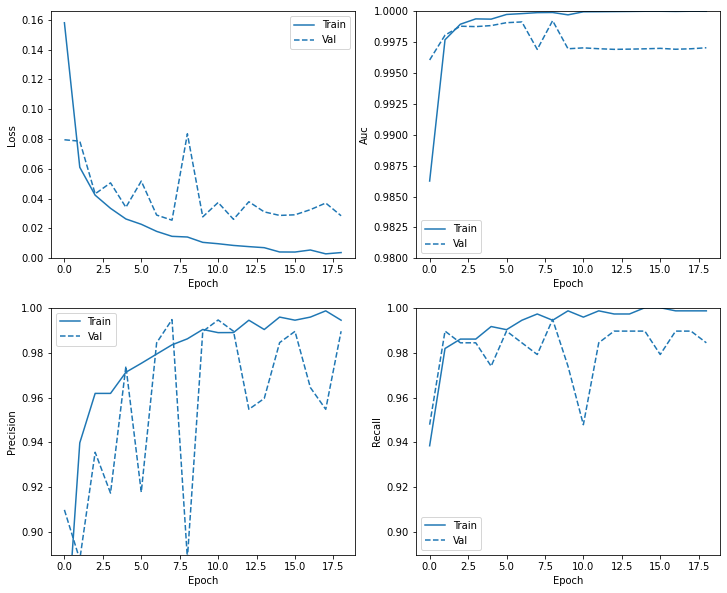

In [175]:
plot_metrics(weighted_vgg_history)

Loss plot looks similar to baseline VGG model. Precision shows a lot of noise.

#### Evaluate metrics

loss :  0.10322743088006973
tp :  91.0
fp :  12.0
tn :  296.0
fn :  1.0
accuracy :  0.9675
precision :  0.88349515
recall :  0.98913044
auc :  0.99520046

No-ships Detected (True Negatives):  296
No-ships Incorrectly Detected (False Positives):  12
Ships Missed (False Negatives):  1
Ships Detected (True Positives):  91
Total Ships:  92


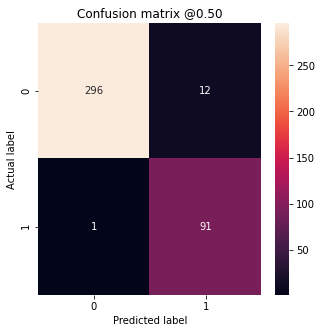

In [347]:
vgg_test_predictions_weights = weighted_vgg_model.predict(vgg_test, batch_size=BATCH_SIZE)
vgg_weights_eval = weighted_vgg_model.evaluate(vgg_test, labels_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_vgg_model.metrics_names, vgg_weights_eval):
  print(name, ': ', value)
print()

_ = plot_cm(labels_test, vgg_test_predictions_weights)

Compared to baseline VGG model, this one has
* less false positives: only 1 ship detected where there is none
* much more false negatives: 12 ships were missed when they were actually present
* a bit lower accuracy but as said before, this may not be the best metric for this task

#### Plot the ROC

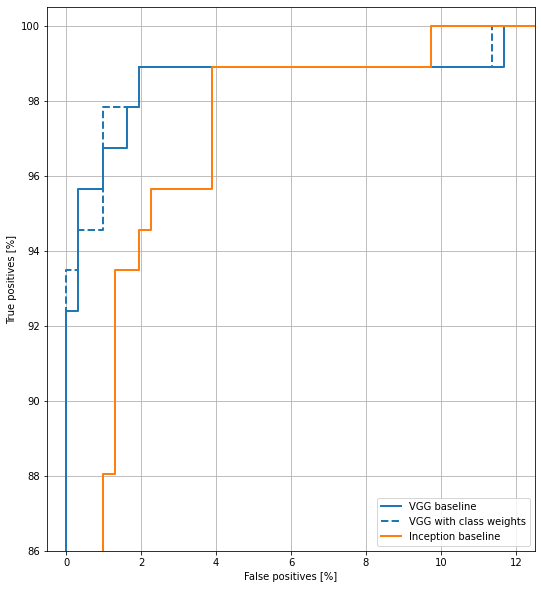

In [303]:
plot_roc("VGG baseline", labels_test, vgg_test_predictions_baseline, color=colors[0])
plot_roc("VGG with class weights", labels_test, vgg_test_predictions_weights, color=colors[0], linestyle='--')
plot_roc("Inception baseline", labels_test, incep_test_predictions_baseline, color=colors[1])
plt.legend(loc='lower right')

### Inception with class weights

Let's see what happens with the previously overfitting Inception model when the same class weights are applied.

#### Train a model with class weights

In [167]:
weighted_incep_model = make_model()
weighted_incep_model.load_weights(initial_weights)

weighted_incep_history = weighted_incep_model.fit(
    incep_train,
    labels_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(incep_dev, labels_dev),
    # The class weights go here
    class_weight=class_weight) 

Train on 2800 samples, validate on 800 samples
Epoch 1/100
2800/2800 [==============================] - 4s 1ms/sample - loss: 0.1903 - tp: 675.0000 - fp: 154.0000 - tn: 1930.0000 - fn: 41.0000 - accuracy: 0.9304 - precision: 0.8142 - recall: 0.9427 - auc: 0.9775 - val_loss: 0.1102 - val_tp: 190.0000 - val_fp: 29.0000 - val_tn: 579.0000 - val_fn: 2.0000 - val_accuracy: 0.9613 - val_precision: 0.8676 - val_recall: 0.9896 - val_auc: 0.9938
Epoch 2/100
2800/2800 [==============================] - 2s 738us/sample - loss: 0.0832 - tp: 702.0000 - fp: 72.0000 - tn: 2012.0000 - fn: 14.0000 - accuracy: 0.9693 - precision: 0.9070 - recall: 0.9804 - auc: 0.9949 - val_loss: 0.0798 - val_tp: 187.0000 - val_fp: 18.0000 - val_tn: 590.0000 - val_fn: 5.0000 - val_accuracy: 0.9712 - val_precision: 0.9122 - val_recall: 0.9740 - val_auc: 0.9943
Epoch 3/100
2800/2800 [==============================] - 2s 743us/sample - loss: 0.0579 - tp: 703.0000 - fp: 42.0000 - tn: 2042.0000 - fn: 13.0000 - accuracy: 0.980

#### Plot training history

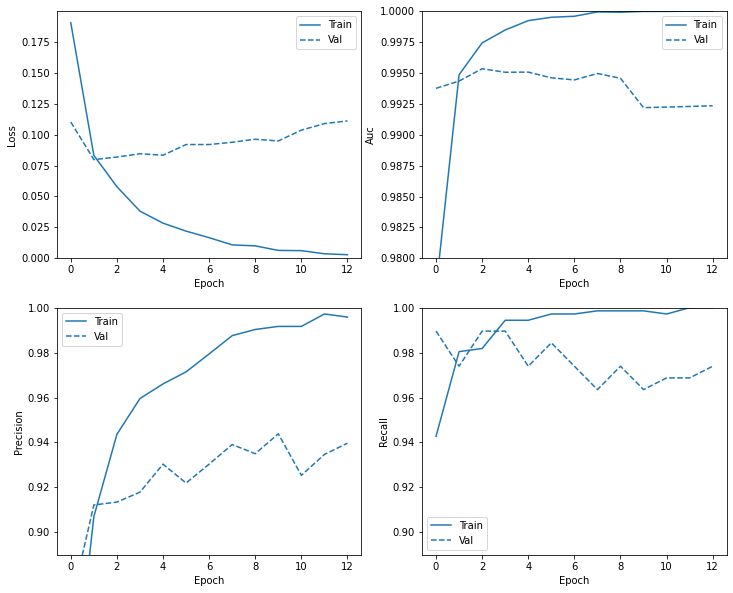

In [177]:
plot_metrics(weighted_incep_history)

Similar overfitting picture. Inception-based model is unlikely to make it to production.

#### Evalate metrics

loss :  0.11990830048918724
tp :  87.0
fp :  8.0
tn :  300.0
fn :  5.0
accuracy :  0.9675
precision :  0.9157895
recall :  0.9456522
auc :  0.9918126

No-ships Detected (True Negatives):  300
No-ships Incorrectly Detected (False Positives):  8
Ships Missed (False Negatives):  5
Ships Detected (True Positives):  87
Total Ships:  92


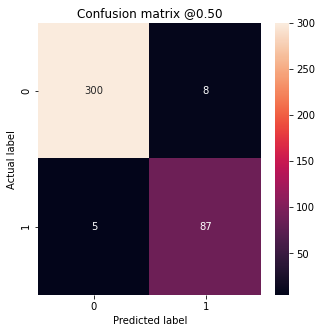

In [348]:
incep_test_predictions_weights = weighted_incep_model.predict(incep_test, batch_size=BATCH_SIZE)
incep_weights_eval = weighted_incep_model.evaluate(incep_test, labels_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_incep_model.metrics_names, incep_weights_eval):
  print(name, ': ', value)
print()

_ = plot_cm(labels_test, incep_test_predictions_weights)

#### Plot the ROC

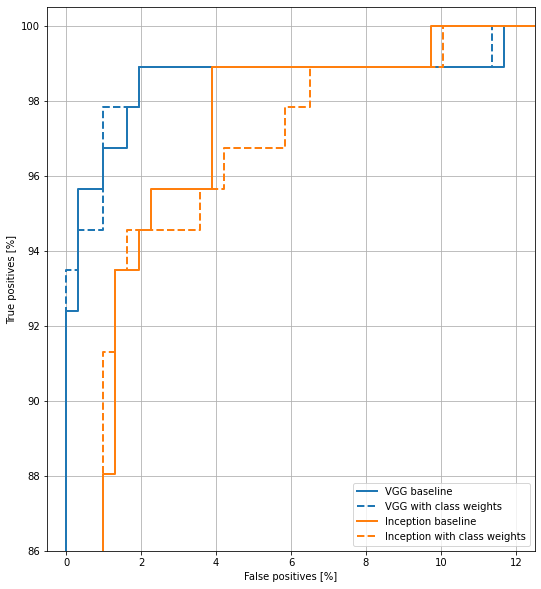

In [304]:
plot_roc("VGG baseline", labels_test, vgg_test_predictions_baseline, color=colors[0])
plot_roc("VGG with class weights", labels_test, vgg_test_predictions_weights, color=colors[0], linestyle='--')
plot_roc("Inception baseline", labels_test, incep_test_predictions_baseline, color=colors[1])
plot_roc("Inception with class weights", labels_test, incep_test_predictions_weights, color=colors[1], linestyle='--')
plt.legend(loc='lower right')

## Data augmentation model

Another way to deal with imbalanced classes is do use data augmentation to create more examples of the minority class.

In [179]:
# this function will create two new images for each one it recieves
def augment_add(images, seq, labels):
    
    augmented_images, augmented_labels = [],[]
    for idx,img in tqdm(enumerate(images)):
        
        if labels[idx] == 1:
            image_aug_1 = seq.augment_image(image=img)
            image_aug_2 = seq.augment_image(image=img)
            augmented_images.append(image_aug_1)
            augmented_images.append(image_aug_2)
            augmented_labels.append(labels[idx])
            augmented_labels.append(labels[idx])
        pass
    
    augmented_images = np.array(augmented_images, dtype=np.float32)
    augmented_labels = np.array(augmented_labels, dtype=np.float32)
    
    return (augmented_images, augmented_labels)

Several ways of augmentation will be applied randomly. Some other ways, like cropping or rotating the image, will not work very well for this case, because the ship usually takes almost the entire image, so we are risking of either cutting away a part of it, or creating significant black corners when rotating the square.

In [180]:
seq = iaa.Sequential([
    iaa.Fliplr(1), # flips left-to-right
    iaa.Flipud(1), # flips upside down (okay for satellite images)
    iaa.LinearContrast((0.75,1.5)), # changes contrast
    iaa.Multiply((0.8,1.2), per_channel=0.2), # changes brightness
], random_order=True)

Augmentation will only be applied to the training set. This way dev and test sets will be same across all models, allowing to compare apples to apples.

In [186]:
np.random.seed(41) # augmentation is a random process so setting the seed for reproducible results
(aug_images, aug_labels) = augment_add(images_train, seq, labels_train)
aug_images = np.concatenate([images_train, aug_images])
aug_labels = np.concatenate([labels_train, aug_labels])

2800it [00:02, 1175.65it/s]


In [187]:
images_train.shape, labels_train.shape, aug_images.shape, aug_labels.shape

((2800, 80, 80, 3), (2800,), (4232, 80, 80, 3), (4232,))

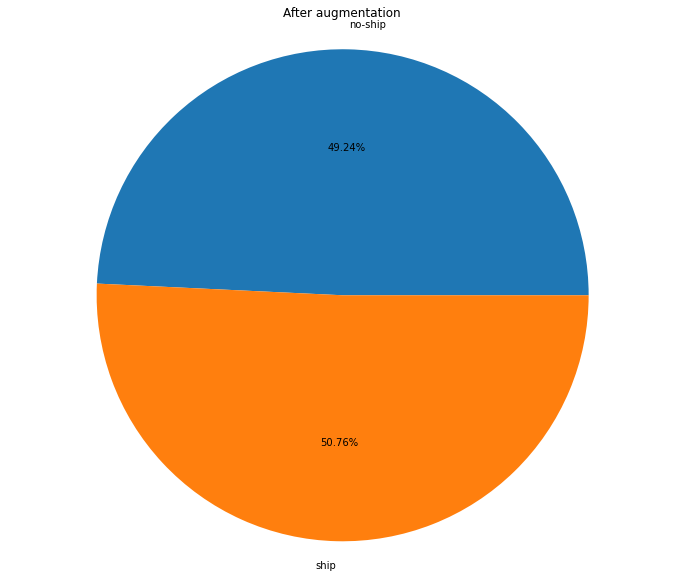

In [188]:
_, count = np.unique(aug_labels, return_counts=True)

plt.pie(count,
       explode=(0,0),
       labels=class_names,
       autopct="%1.2f%%")
plt.axis('equal')
plt.title("After augmentation");

An (almost) balanced dataset (original `images_train` was not exactly 3:1 ratio due random nature of tran/dev/test splitting)

### VGG16 with augmentation

#### Calculate VGG16 features
I now have some more training example for which the features have to be calculated and flattened again.

In [190]:
vgg_train_aug = vgg_conv.predict(aug_images)
vgg_train_aug.shape

(4232, 2, 2, 512)

In [191]:
vgg_train_aug = flatten(vgg_train_aug)
vgg_train_aug.shape

(4232, 2048)

#### Train a model with augmented data

In [192]:
aug_vgg_model = make_model()
aug_vgg_model.load_weights(initial_weights)
aug_vgg_history = aug_vgg_model.fit(
    vgg_train_aug,
    aug_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(vgg_dev, labels_dev))

Train on 4232 samples, validate on 800 samples
Epoch 1/100
4232/4232 [==============================] - 5s 1ms/sample - loss: 0.1414 - tp: 2042.0000 - fp: 131.0000 - tn: 1953.0000 - fn: 106.0000 - accuracy: 0.9440 - precision: 0.9397 - recall: 0.9507 - auc: 0.9886 - val_loss: 0.0660 - val_tp: 184.0000 - val_fp: 14.0000 - val_tn: 594.0000 - val_fn: 8.0000 - val_accuracy: 0.9725 - val_precision: 0.9293 - val_recall: 0.9583 - val_auc: 0.9970
Epoch 2/100
4232/4232 [==============================] - 3s 722us/sample - loss: 0.0571 - tp: 2111.0000 - fp: 49.0000 - tn: 2035.0000 - fn: 37.0000 - accuracy: 0.9797 - precision: 0.9773 - recall: 0.9828 - auc: 0.9978 - val_loss: 0.0479 - val_tp: 190.0000 - val_fp: 14.0000 - val_tn: 594.0000 - val_fn: 2.0000 - val_accuracy: 0.9800 - val_precision: 0.9314 - val_recall: 0.9896 - val_auc: 0.9987
Epoch 3/100
4232/4232 [==============================] - 3s 714us/sample - loss: 0.0354 - tp: 2120.0000 - fp: 30.0000 - tn: 2054.0000 - fn: 28.0000 - accuracy: 0

#### Plot training history

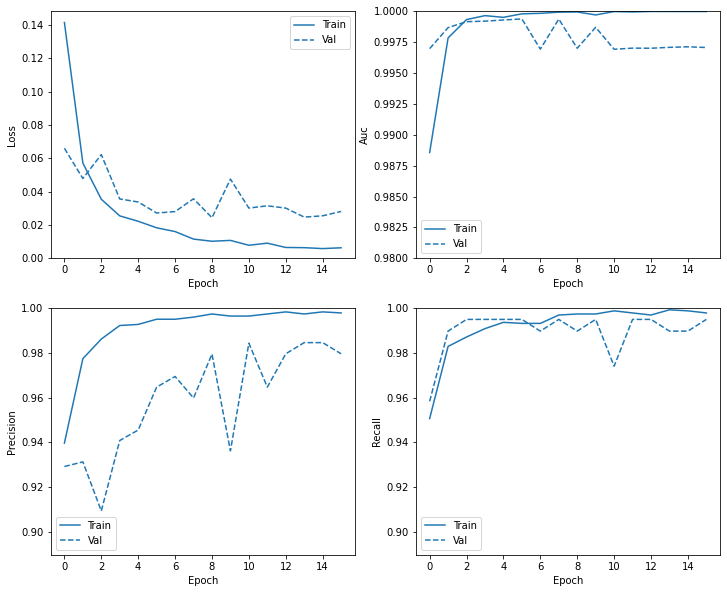

In [193]:
plot_metrics(aug_vgg_history)

#### Evaluate metrics

loss :  0.03780091498978436
tp :  90.0
fp :  4.0
tn :  304.0
fn :  2.0
accuracy :  0.985
precision :  0.9574468
recall :  0.9782609
auc :  0.9936829

No-ships Detected (True Negatives):  304
No-ships Incorrectly Detected (False Positives):  4
Ships Missed (False Negatives):  2
Ships Detected (True Positives):  90
Total Ships:  92


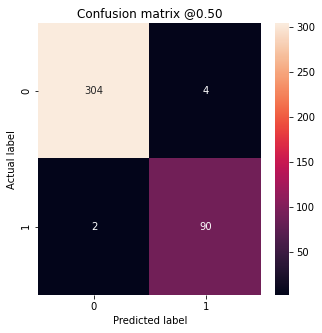

In [349]:
vgg_test_predictions_aug = aug_vgg_model.predict(vgg_test, batch_size=BATCH_SIZE)
vgg_aug_eval = aug_vgg_model.evaluate(vgg_test, labels_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(aug_vgg_model.metrics_names, vgg_aug_eval):
  print(name, ': ', value)
print()

_ = plot_cm(labels_test, vgg_test_predictions_aug)

Compared with the defending champion (baseline VGG model), this one has a tiny tiny improvement: one false positive less (therefore higher precision) and also a bit better AUC. This is the world of modern computer vision: fighting for improvements somewhere in the forth digit after the point.

#### Plot the ROC

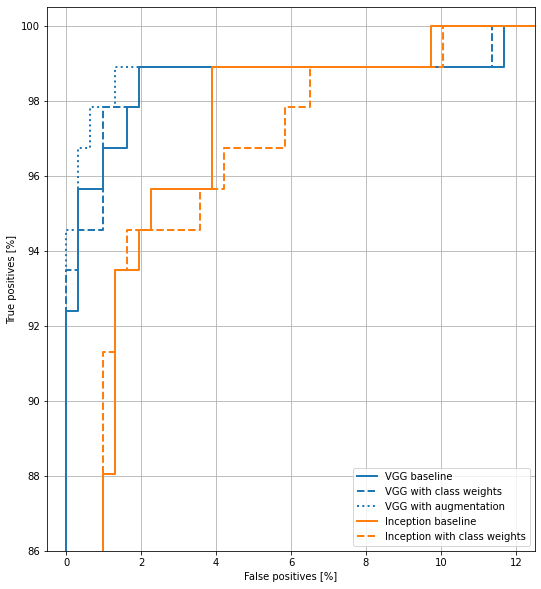

In [305]:
plot_roc("VGG baseline", labels_test, vgg_test_predictions_baseline, color=colors[0])
plot_roc("VGG with class weights", labels_test, vgg_test_predictions_weights, color=colors[0], linestyle='--')
plot_roc("VGG with augmentation", labels_test, vgg_test_predictions_aug, color=colors[0], linestyle=':')
plot_roc("Inception baseline", labels_test, incep_test_predictions_baseline, color=colors[1])
plot_roc("Inception with class weights", labels_test, incep_test_predictions_weights, color=colors[1], linestyle='--')
plt.legend(loc='lower right')

### Inception with augmentation
Last chance for Inception based model. Maybe with more training data there will be less overfitting?

#### Calculate Inception features

In [195]:
incep_train_aug = incep_conv.predict(aug_images)
incep_train_aug.shape

(4232, 1, 1, 2048)

In [196]:
incep_train_aug = flatten(incep_train_aug)
incep_train_aug.shape

(4232, 2048)

#### Train a model with augmented data

In [197]:
aug_incep_model = make_model()
aug_incep_model.load_weights(initial_weights)
aug_incep_history = aug_incep_model.fit(
    incep_train_aug,
    aug_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(incep_dev, labels_dev))

Train on 4232 samples, validate on 800 samples
Epoch 1/100
4232/4232 [==============================] - 5s 1ms/sample - loss: 0.1655 - tp: 2060.0000 - fp: 161.0000 - tn: 1923.0000 - fn: 88.0000 - accuracy: 0.9412 - precision: 0.9275 - recall: 0.9590 - auc: 0.9817 - val_loss: 0.1020 - val_tp: 191.0000 - val_fp: 26.0000 - val_tn: 582.0000 - val_fn: 1.0000 - val_accuracy: 0.9663 - val_precision: 0.8802 - val_recall: 0.9948 - val_auc: 0.9943
Epoch 2/100
4232/4232 [==============================] - 3s 744us/sample - loss: 0.0722 - tp: 2108.0000 - fp: 64.0000 - tn: 2020.0000 - fn: 40.0000 - accuracy: 0.9754 - precision: 0.9705 - recall: 0.9814 - auc: 0.9964 - val_loss: 0.0916 - val_tp: 191.0000 - val_fp: 20.0000 - val_tn: 588.0000 - val_fn: 1.0000 - val_accuracy: 0.9737 - val_precision: 0.9052 - val_recall: 0.9948 - val_auc: 0.9943
Epoch 3/100
4232/4232 [==============================] - 3s 732us/sample - loss: 0.0426 - tp: 2127.0000 - fp: 35.0000 - tn: 2049.0000 - fn: 21.0000 - accuracy: 0.

#### Plot training history

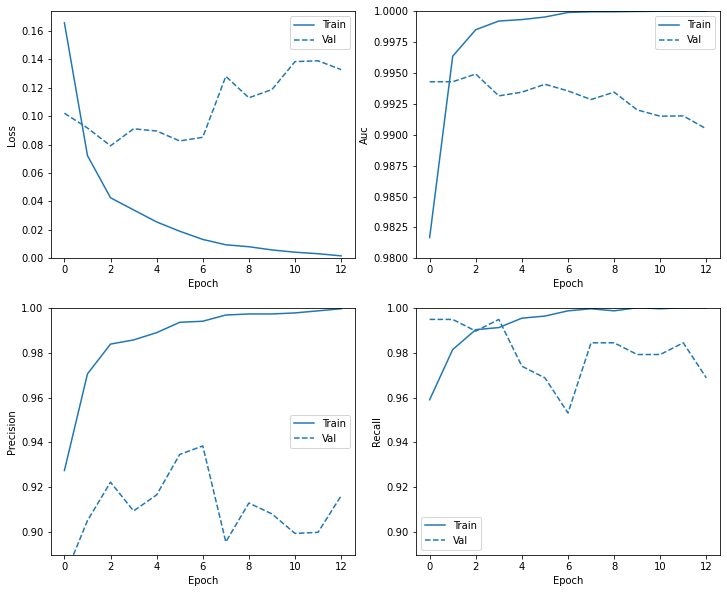

In [198]:
plot_metrics(aug_incep_history)

Wow, the more data it gets, the worse it performs. Too bad for you, Inception!

#### Evaluate metrics

loss :  0.11528322748839855
tp :  88.0
fp :  7.0
tn :  301.0
fn :  4.0
accuracy :  0.9725
precision :  0.9263158
recall :  0.95652175
auc :  0.99107134

No-ships Detected (True Negatives):  301
No-ships Incorrectly Detected (False Positives):  7
Ships Missed (False Negatives):  4
Ships Detected (True Positives):  88
Total Ships:  92


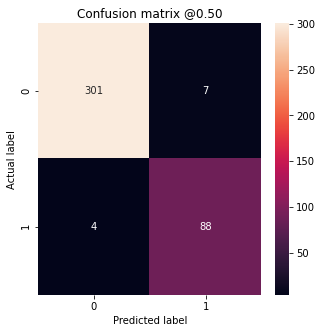

In [350]:
incep_test_predictions_aug = aug_incep_model.predict(incep_test, batch_size=BATCH_SIZE)
incep_aug_eval = aug_incep_model.evaluate(incep_test, labels_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(aug_incep_model.metrics_names, incep_aug_eval):
  print(name, ': ', value)
print()

_ = plot_cm(labels_test, incep_test_predictions_aug)

#### Plot the ROC

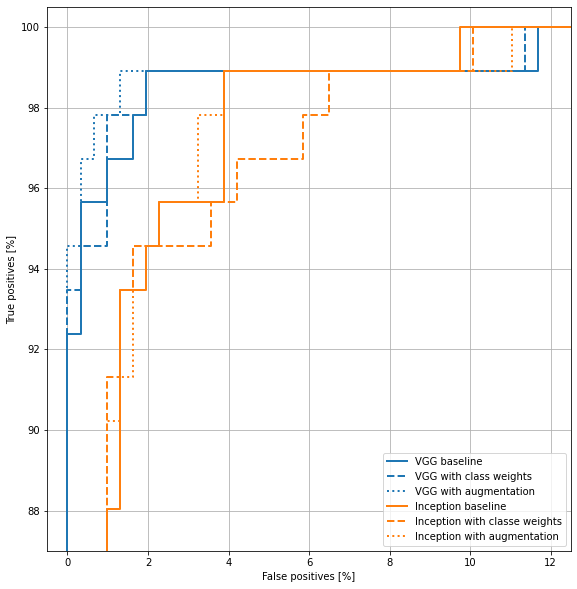

In [309]:
plot_roc("VGG baseline", labels_test, vgg_test_predictions_baseline, color=colors[0])
plot_roc("VGG with class weights", labels_test, vgg_test_predictions_weights, color=colors[0], linestyle='--')
plot_roc("VGG with augmentation", labels_test, vgg_test_predictions_aug, color=colors[0], linestyle=':')
plot_roc("Inception baseline", labels_test, incep_test_predictions_baseline, color=colors[1])
plot_roc("Inception with classe weights", labels_test, incep_test_predictions_weights, color=colors[1], linestyle='--')
plot_roc("Inception with augmentation", labels_test, incep_test_predictions_aug, color=colors[1], linestyle=':')
plt.legend(loc='lower right')

# Final model

In the previous section, I trained a total of 6 classifiers = 2 underlying embeddings (VGG16 and Inception) x 3 options for each embedding (baseline, class weights and data augmentation). Time to compare all of them together.

## Compare six mod

In [246]:
# build a dataframe with all models' metrics
chart = pd.DataFrame(columns = model.metrics_names)
for m in [vgg_baseline_eval, incep_baseline_eval, vgg_weights_eval, incep_weights_eval, vgg_aug_eval, incep_aug_eval]:
    chart.loc[len(chart)] = m
models = ['vgg_baseline', 'incep_baseline', 'vgg_weights', 'incep_weights', 'vgg_augment', 'incep_augment']
chart['model'] = models
chart.set_index('model', inplace=True)
chart['F1'] = 2 * chart['precision'] * chart['recall'] / (chart['precision'] + chart['recall'])

chart.sort_values(by='F1', ascending=False)

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,F1
model,,,,,,,,,,
vgg_augment,0.037801,90.0,4.0,304.0,2.0,0.9850,0.957447,0.978261,0.993683,0.967742
vgg_baseline,0.048311,89.0,4.0,304.0,3.0,0.9825,0.956989,0.967391,0.993436,0.962162
incep_augment,0.115283,88.0,7.0,301.0,4.0,0.9725,0.926316,0.956522,0.991071,0.941176
incep_baseline,0.094018,86.0,5.0,303.0,6.0,0.9725,0.945055,0.934783,0.993471,0.939891
vgg_weights,0.103227,91.0,12.0,296.0,1.0,0.9675,0.883495,0.989130,0.995200,0.933333
incep_weights,0.119908,87.0,8.0,300.0,5.0,0.9675,0.915789,0.945652,0.991813,0.930481


Without having a specific business problem to solve, it is hard to choose between six models, all showing decent performance (even the worst one gives 96.75% accuracy). It is always good to use a single real-value metric to compare all the models, but what should it be? Three options come to mind:
1. Raw accuracy
2. F1 score
3. AUC-ROC

VGG-based model with augmented data scores best both in terms of accuracy (only 6 mislabelled examples out of 400, or 98.5%) and F1 score. However, VGG-based model with class weights scores better on AUC-ROC metric.

## Adjust VGG with class weights
With current decision treshold of 0.5, this model found 12 false positive ships where there are none (and missed one true ship), but here is what we can get of it by simple rising that threshold. I played with p manually until I found the value that yields the least false positives without adding any new false negatives. This may be considered data leakage, as I am adjusting the threshold according to test data, so I would not do this in production, but here my task is just to show whate I can theoretically squeeze out of this model.  

No-ships Detected (True Negatives):  302
No-ships Incorrectly Detected (False Positives):  6
Ships Missed (False Negatives):  1
Ships Detected (True Positives):  91
Total Ships:  92


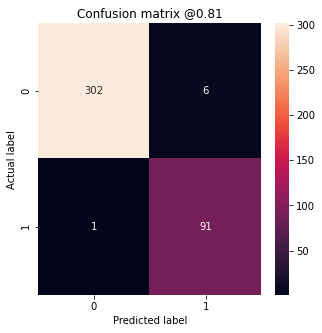

In [352]:
cm = plot_cm(labels_test, vgg_test_predictions_weights, p=0.81) 

If my goal was not to miss an actual ship at any cost, this would probably be my best choice. Let's manually calculate precision, recall and F1 score for this model:

In [356]:
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]
precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1 = 2 * precision * recall / (precision + recall)
print("Improved F1 score for VGG based model with class weights: %.3f" % f1)

Improved F1 score for VGG based model with class weights: 0.963


So even with this cheating adjustment of threshold on test data, the F1 score does not beat data augmentation model's one.

# Display wrongly labelled test pics

In [126]:
# Get IDs of the wrongly labelled test images in the original (before shuffling) numeration
error_ids = np.array([test_ids[i] for i in errors], dtype=np.int32)
error_truth = np.array([test_labels[i] for i in errors], dtype=np.int32)[:,1] # get ship/noship labels as just 1 and 0
false_positives = error_ids[error_truth==0]
false_negatives = error_ids[error_truth==1]
print("There are {} false positives and {} false negatives".format(len(false_positives), len(false_negatives)))

There are 4 false positives and 6 false negatives


False positives:

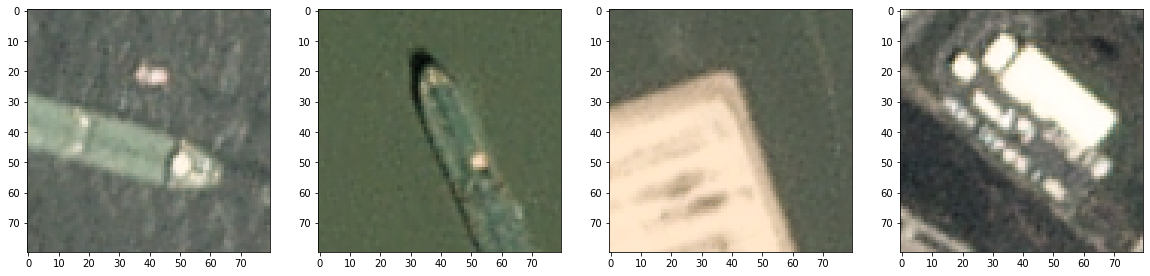

In [127]:
columns = 4
rows = 1

fig=plt.figure(figsize=(20, 20))
for i in range(1, columns*rows +1):
    img = images[false_positives[i-1]]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

False negatives:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


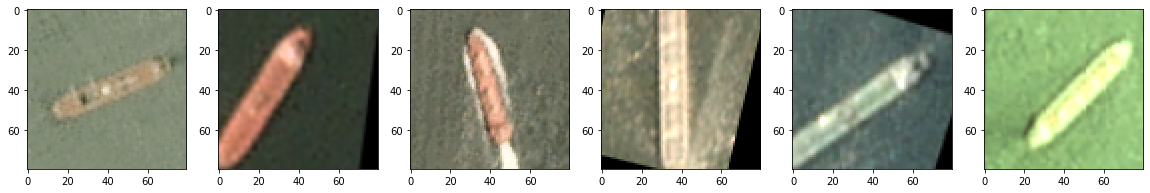

In [129]:
columns = 6
rows = 1

fig=plt.figure(figsize=(20, 20))
for i in range(1, columns*rows +1):
    img = images[false_negatives[i-1]]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [136]:
import dill as pickle
with open('images.dill', 'wb') as file:
    pickle.dump(images, file)

In [137]:
model.save('model.h5')